Convolutional Dictionary Learning
=================================

This example demonstrates the use of [dictlrn.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.cbpdndl.html#sporco.dictlrn.cbpdndl.ConvBPDNDictLearn) for learning a 3D convolutional dictionary from video data. The dictionary learning algorithm is based on the ADMM consensus dictionary update.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np
from scipy.ndimage import zoom
import imageio

from sporco.dictlrn import cbpdndl
from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()

Construct 3D training array from video data

In [2]:
reader = imageio.get_reader('imageio:cockatoo.mp4')
frmlst = []
for i, frm in enumerate(reader):
    if i >= 250:
        frm = zoom(signal.rgb2gray(frm.astype(np.float32)/255.0), 0.25)
        frmlst.append(frm[20:-20, 70:-70])
vid = np.stack(frmlst, axis=2)

Highpass filter video frames.

In [3]:
npd = 16
fltlmbd = 10
vl, vh = signal.tikhonov_filter(vid, fltlmbd, npd)

Construct initial dictionary.

In [4]:
np.random.seed(12345)
D0 = np.random.randn(5, 5, 3, 25)

Set regularization parameter and options for dictionary learning solver.

In [5]:
lmbda = 0.1
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 200,
                'CBPDN': {'rho': 5e1*lmbda, 'AutoRho': {'Enabled': True}},
                'CCMOD': {'rho': 1e2, 'AutoRho': {'Enabled': True}}},
                dmethod='cns')

Create solver object and solve.

In [6]:
d = cbpdndl.ConvBPDNDictLearn(D0, vh, lmbda, opt, dimK=0, dimN=3)
D1 = d.solve()
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'))

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------


   0  1.81e+03  2.65e+01  1.79e+04  6.58e-07  9.70e-01  8.66e-02  5.00e+00  2.32e-01  1.75e-01  1.00e+02


   1  1.28e+03  1.21e+02  1.16e+04  5.67e-07  8.14e-01  2.16e-01  5.00e+00  2.54e-01  2.08e-01  1.00e+02


   2  1.12e+03  1.46e+02  9.70e+03  4.41e-07  4.36e-01  2.24e-01  5.00e+00  2.43e-01  1.52e-01  1.00e+02


   3  1.05e+03  1.39e+02  9.06e+03  4.52e-07  3.17e-01  1.91e-01  5.00e+00  2.07e-01  9.86e-02  1.00e+02


   4  9.57e+02  1.30e+02  8.26e+03  4.31e-07  2.61e-01  1.54e-01  5.00e+00  1.72e-01  8.04e-02  1.00e+02


   5  8.33e+02  1.27e+02  7.06e+03  4.89e-07  2.15e-01  1.25e-01  5.00e+00  1.40e-01  7.30e-02  1.00e+02


   6  7.46e+02  1.28e+02  6.18e+03  5.15e-07  1.81e-01  9.93e-02  5.00e+00  1.16e-01  7.15e-02  1.00e+02


   7  6.91e+02  1.29e+02  5.62e+03  4.69e-07  1.50e-01  7.95e-02  5.00e+00  9.41e-02  6.44e-02  1.00e+02


   8  6.52e+02  1.29e+02  5.22e+03  3.80e-07  1.26e-01  6.82e-02  5.00e+00  7.88e-02  5.81e-02  1.00e+02


   9  6.27e+02  1.29e+02  4.98e+03  4.66e-07  1.08e-01  6.13e-02  5.00e+00  6.70e-02  5.35e-02  1.00e+02


  10  6.05e+02  1.28e+02  4.77e+03  4.82e-07  9.41e-02  5.47e-02  5.00e+00  5.68e-02  5.05e-02  1.00e+02


  11  5.92e+02  1.27e+02  4.65e+03  4.98e-07  8.37e-02  4.90e-02  5.00e+00  4.91e-02  4.77e-02  1.00e+02


  12  5.72e+02  1.25e+02  4.46e+03  4.85e-07  7.46e-02  4.49e-02  5.00e+00  4.33e-02  4.52e-02  1.00e+02


  13  5.54e+02  1.24e+02  4.30e+03  5.24e-07  6.74e-02  4.15e-02  5.00e+00  3.88e-02  4.27e-02  1.00e+02


  14  5.37e+02  1.23e+02  4.14e+03  6.40e-07  6.11e-02  3.85e-02  5.00e+00  3.49e-02  4.07e-02  1.00e+02


  15  5.26e+02  1.23e+02  4.03e+03  4.56e-07  5.62e-02  3.57e-02  5.00e+00  3.19e-02  3.87e-02  1.00e+02


  16  5.15e+02  1.22e+02  3.93e+03  4.59e-07  5.18e-02  3.32e-02  5.00e+00  2.89e-02  3.69e-02  1.00e+02


  17  5.07e+02  1.21e+02  3.86e+03  4.83e-07  4.83e-02  3.14e-02  5.00e+00  2.68e-02  3.52e-02  1.00e+02


  18  4.99e+02  1.21e+02  3.78e+03  4.72e-07  4.51e-02  2.98e-02  5.00e+00  2.49e-02  3.37e-02  1.00e+02


  19  4.92e+02  1.20e+02  3.72e+03  5.05e-07  4.26e-02  2.83e-02  5.00e+00  2.33e-02  3.21e-02  1.00e+02


  20  4.84e+02  1.19e+02  3.65e+03  3.56e-07  4.01e-02  2.69e-02  5.00e+00  2.18e-02  3.07e-02  1.00e+02


  21  4.78e+02  1.19e+02  3.59e+03  4.07e-07  3.81e-02  2.56e-02  5.00e+00  2.06e-02  2.94e-02  1.00e+02


  22  4.71e+02  1.18e+02  3.53e+03  4.36e-07  3.61e-02  2.44e-02  5.00e+00  1.95e-02  2.81e-02  1.00e+02


  23  4.66e+02  1.18e+02  3.48e+03  4.46e-07  3.44e-02  2.33e-02  5.00e+00  1.85e-02  2.69e-02  1.00e+02


  24  4.61e+02  1.18e+02  3.44e+03  6.63e-07  3.27e-02  2.23e-02  5.00e+00  1.76e-02  2.57e-02  1.00e+02


  25  4.57e+02  1.17e+02  3.40e+03  5.37e-07  3.13e-02  2.14e-02  5.00e+00  1.67e-02  2.47e-02  1.00e+02


  26  4.53e+02  1.17e+02  3.36e+03  5.36e-07  2.98e-02  2.06e-02  5.00e+00  1.60e-02  2.37e-02  1.00e+02


  27  4.49e+02  1.16e+02  3.33e+03  5.55e-07  2.85e-02  1.98e-02  5.00e+00  1.53e-02  2.28e-02  1.00e+02


  28  4.45e+02  1.16e+02  3.29e+03  4.10e-07  2.73e-02  1.91e-02  5.00e+00  1.46e-02  2.19e-02  1.00e+02


  29  4.42e+02  1.16e+02  3.26e+03  4.81e-07  2.62e-02  1.85e-02  5.00e+00  1.40e-02  2.11e-02  1.00e+02


  30  4.38e+02  1.16e+02  3.23e+03  4.57e-07  2.51e-02  1.78e-02  5.00e+00  1.34e-02  2.04e-02  1.00e+02


  31  4.35e+02  1.15e+02  3.20e+03  4.38e-07  2.41e-02  1.72e-02  5.00e+00  1.29e-02  1.97e-02  1.00e+02


  32  4.32e+02  1.15e+02  3.17e+03  4.12e-07  2.32e-02  1.67e-02  5.00e+00  1.23e-02  1.90e-02  1.00e+02


  33  4.29e+02  1.15e+02  3.15e+03  4.41e-07  2.23e-02  1.61e-02  5.00e+00  1.19e-02  1.84e-02  1.00e+02


  34  4.27e+02  1.15e+02  3.12e+03  4.55e-07  2.14e-02  1.55e-02  5.00e+00  1.14e-02  1.78e-02  1.00e+02


  35  4.24e+02  1.14e+02  3.10e+03  4.78e-07  2.06e-02  1.51e-02  5.00e+00  1.10e-02  1.72e-02  1.00e+02


  36  4.22e+02  1.14e+02  3.08e+03  4.47e-07  1.99e-02  1.46e-02  5.00e+00  1.06e-02  1.67e-02  1.00e+02


  37  4.19e+02  1.14e+02  3.06e+03  4.05e-07  1.92e-02  1.42e-02  5.00e+00  1.02e-02  1.62e-02  1.00e+02


  38  4.17e+02  1.14e+02  3.04e+03  5.72e-07  1.85e-02  1.38e-02  5.00e+00  9.91e-03  1.57e-02  1.00e+02


  39  4.15e+02  1.14e+02  3.02e+03  4.77e-07  1.79e-02  1.34e-02  5.00e+00  9.60e-03  1.53e-02  1.00e+02


  40  4.14e+02  1.13e+02  3.00e+03  4.22e-07  1.74e-02  1.31e-02  5.00e+00  9.31e-03  1.49e-02  1.00e+02


  41  4.12e+02  1.13e+02  2.99e+03  4.58e-07  1.68e-02  1.27e-02  5.00e+00  9.05e-03  1.45e-02  1.00e+02


  42  4.10e+02  1.13e+02  2.97e+03  6.47e-07  1.63e-02  1.24e-02  5.00e+00  8.78e-03  1.41e-02  1.00e+02


  43  4.09e+02  1.13e+02  2.96e+03  4.38e-07  1.59e-02  1.20e-02  5.00e+00  8.54e-03  1.38e-02  1.00e+02


  44  4.07e+02  1.13e+02  2.95e+03  4.22e-07  1.54e-02  1.17e-02  5.00e+00  8.30e-03  1.34e-02  1.00e+02


  45  4.06e+02  1.13e+02  2.93e+03  5.59e-07  1.50e-02  1.15e-02  5.00e+00  8.08e-03  1.31e-02  1.00e+02


  46  4.05e+02  1.12e+02  2.92e+03  4.07e-07  1.46e-02  1.12e-02  5.00e+00  7.88e-03  1.28e-02  1.00e+02


  47  4.03e+02  1.12e+02  2.91e+03  4.27e-07  1.42e-02  1.09e-02  5.00e+00  7.68e-03  1.25e-02  1.00e+02


  48  4.02e+02  1.12e+02  2.90e+03  4.77e-07  1.39e-02  1.07e-02  5.00e+00  7.49e-03  1.23e-02  1.00e+02


  49  4.01e+02  1.12e+02  2.89e+03  6.24e-07  1.35e-02  1.04e-02  5.00e+00  7.31e-03  1.20e-02  1.00e+02


  50  4.00e+02  1.12e+02  2.88e+03  4.50e-07  1.32e-02  1.02e-02  5.00e+00  7.15e-03  1.17e-02  1.00e+02


  51  3.99e+02  1.12e+02  2.87e+03  5.01e-07  1.29e-02  1.00e-02  5.00e+00  6.98e-03  1.15e-02  1.00e+02


  52  3.98e+02  1.12e+02  2.86e+03  5.58e-07  1.26e-02  9.80e-03  5.00e+00  6.83e-03  1.13e-02  1.00e+02


  53  3.97e+02  1.12e+02  2.85e+03  4.42e-07  1.23e-02  9.61e-03  5.00e+00  6.69e-03  1.11e-02  1.00e+02


  54  3.96e+02  1.12e+02  2.84e+03  5.76e-07  1.21e-02  9.43e-03  5.00e+00  6.56e-03  1.09e-02  1.00e+02


  55  3.95e+02  1.12e+02  2.83e+03  4.19e-07  1.18e-02  9.26e-03  5.00e+00  6.44e-03  1.07e-02  1.00e+02


  56  3.94e+02  1.11e+02  2.83e+03  5.04e-07  1.16e-02  9.10e-03  5.00e+00  6.32e-03  1.05e-02  1.00e+02


  57  3.93e+02  1.11e+02  2.82e+03  4.42e-07  1.14e-02  8.94e-03  5.00e+00  6.20e-03  1.03e-02  1.00e+02


  58  3.93e+02  1.11e+02  2.81e+03  5.27e-07  1.12e-02  8.78e-03  5.00e+00  6.09e-03  1.01e-02  1.00e+02


  59  3.92e+02  1.11e+02  2.81e+03  4.72e-07  1.10e-02  8.64e-03  5.00e+00  5.99e-03  9.97e-03  1.00e+02


  60  3.91e+02  1.11e+02  2.80e+03  4.78e-07  1.08e-02  8.50e-03  5.00e+00  5.89e-03  9.80e-03  1.00e+02


  61  3.90e+02  1.11e+02  2.79e+03  5.22e-07  1.06e-02  8.36e-03  5.00e+00  5.79e-03  9.65e-03  1.00e+02


  62  3.90e+02  1.11e+02  2.79e+03  4.11e-07  1.05e-02  8.22e-03  5.00e+00  5.69e-03  9.49e-03  1.00e+02


  63  3.89e+02  1.11e+02  2.78e+03  4.77e-07  1.03e-02  8.09e-03  5.00e+00  5.61e-03  9.34e-03  1.00e+02


  64  3.89e+02  1.11e+02  2.78e+03  4.44e-07  1.02e-02  7.97e-03  5.00e+00  5.51e-03  9.20e-03  1.00e+02


  65  3.88e+02  1.11e+02  2.77e+03  5.57e-07  1.00e-02  7.85e-03  5.00e+00  5.44e-03  9.06e-03  1.00e+02


  66  3.87e+02  1.11e+02  2.77e+03  5.89e-07  9.86e-03  7.74e-03  5.00e+00  5.35e-03  8.93e-03  1.00e+02


  67  3.87e+02  1.11e+02  2.76e+03  5.05e-07  9.73e-03  7.63e-03  5.00e+00  5.28e-03  8.80e-03  1.00e+02


  68  3.86e+02  1.11e+02  2.76e+03  3.69e-07  9.60e-03  7.52e-03  5.00e+00  5.21e-03  8.67e-03  1.00e+02


  69  3.86e+02  1.11e+02  2.75e+03  5.43e-07  9.47e-03  7.41e-03  5.00e+00  5.13e-03  8.54e-03  1.00e+02


  70  3.85e+02  1.10e+02  2.75e+03  4.48e-07  9.35e-03  7.31e-03  5.00e+00  5.07e-03  8.42e-03  1.00e+02


  71  3.85e+02  1.10e+02  2.75e+03  4.18e-07  9.23e-03  7.22e-03  5.00e+00  5.00e-03  8.30e-03  1.00e+02


  72  3.85e+02  1.10e+02  2.74e+03  4.74e-07  9.12e-03  7.13e-03  5.00e+00  4.95e-03  8.18e-03  1.00e+02


  73  3.84e+02  1.10e+02  2.74e+03  4.25e-07  9.01e-03  7.05e-03  5.00e+00  4.88e-03  8.06e-03  1.00e+02


  74  3.84e+02  1.10e+02  2.73e+03  4.70e-07  8.91e-03  6.97e-03  5.00e+00  4.83e-03  7.94e-03  1.00e+02


  75  3.83e+02  1.10e+02  2.73e+03  4.88e-07  8.82e-03  6.89e-03  5.00e+00  4.77e-03  7.82e-03  1.00e+02


  76  3.83e+02  1.10e+02  2.73e+03  4.55e-07  8.72e-03  6.81e-03  5.00e+00  4.72e-03  7.71e-03  1.00e+02


  77  3.82e+02  1.10e+02  2.72e+03  4.89e-07  8.61e-03  6.74e-03  5.00e+00  4.66e-03  7.59e-03  1.00e+02


  78  3.82e+02  1.10e+02  2.72e+03  4.65e-07  8.51e-03  6.66e-03  5.00e+00  4.60e-03  7.47e-03  1.00e+02


  79  3.81e+02  1.10e+02  2.71e+03  4.91e-07  8.40e-03  6.57e-03  5.00e+00  4.54e-03  7.35e-03  1.00e+02


  80  3.81e+02  1.10e+02  2.71e+03  4.55e-07  8.28e-03  6.49e-03  5.00e+00  4.47e-03  7.23e-03  1.00e+02


  81  3.81e+02  1.10e+02  2.71e+03  4.97e-07  8.17e-03  6.41e-03  5.00e+00  4.41e-03  7.10e-03  1.00e+02


  82  3.80e+02  1.10e+02  2.70e+03  4.22e-07  8.06e-03  6.34e-03  5.00e+00  4.36e-03  6.98e-03  1.00e+02


  83  3.80e+02  1.10e+02  2.70e+03  4.05e-07  7.95e-03  6.27e-03  5.00e+00  4.30e-03  6.86e-03  1.00e+02


  84  3.79e+02  1.10e+02  2.70e+03  5.46e-07  7.84e-03  6.20e-03  5.00e+00  4.25e-03  6.74e-03  1.00e+02


  85  3.79e+02  1.10e+02  2.69e+03  5.53e-07  7.74e-03  6.13e-03  5.00e+00  4.19e-03  6.63e-03  1.00e+02


  86  3.78e+02  1.10e+02  2.69e+03  5.46e-07  7.63e-03  6.06e-03  5.00e+00  4.15e-03  6.53e-03  1.00e+02


  87  3.78e+02  1.10e+02  2.69e+03  4.79e-07  7.53e-03  5.99e-03  5.00e+00  4.09e-03  6.43e-03  1.00e+02


  88  3.78e+02  1.10e+02  2.68e+03  5.08e-07  7.44e-03  5.93e-03  5.00e+00  4.04e-03  6.33e-03  1.00e+02


  89  3.77e+02  1.09e+02  2.68e+03  4.89e-07  7.35e-03  5.86e-03  5.00e+00  4.00e-03  6.23e-03  1.00e+02


  90  3.77e+02  1.09e+02  2.68e+03  5.32e-07  7.27e-03  5.80e-03  5.00e+00  3.95e-03  6.14e-03  1.00e+02


  91  3.77e+02  1.09e+02  2.67e+03  3.63e-07  7.18e-03  5.74e-03  5.00e+00  3.91e-03  6.05e-03  1.00e+02


  92  3.76e+02  1.09e+02  2.67e+03  4.92e-07  7.10e-03  5.68e-03  5.00e+00  3.86e-03  5.96e-03  1.00e+02


  93  3.76e+02  1.09e+02  2.67e+03  4.87e-07  7.01e-03  5.62e-03  5.00e+00  3.82e-03  5.88e-03  1.00e+02


  94  3.76e+02  1.09e+02  2.67e+03  4.88e-07  6.93e-03  5.56e-03  5.00e+00  3.78e-03  5.80e-03  1.00e+02


  95  3.76e+02  1.09e+02  2.66e+03  5.03e-07  6.85e-03  5.51e-03  5.00e+00  3.74e-03  5.72e-03  1.00e+02


  96  3.75e+02  1.09e+02  2.66e+03  5.52e-07  6.77e-03  5.46e-03  5.00e+00  3.71e-03  5.64e-03  1.00e+02


  97  3.75e+02  1.09e+02  2.66e+03  3.23e-07  6.69e-03  5.40e-03  5.00e+00  3.66e-03  5.56e-03  1.00e+02


  98  3.75e+02  1.09e+02  2.66e+03  5.30e-07  6.61e-03  5.35e-03  5.00e+00  3.63e-03  5.49e-03  1.00e+02


  99  3.75e+02  1.09e+02  2.65e+03  4.07e-07  6.55e-03  5.30e-03  5.00e+00  3.59e-03  5.43e-03  1.00e+02


 100  3.74e+02  1.09e+02  2.65e+03  6.25e-07  6.48e-03  5.26e-03  5.00e+00  3.57e-03  5.37e-03  1.00e+02


 101  3.74e+02  1.09e+02  2.65e+03  5.88e-07  6.41e-03  5.20e-03  5.00e+00  3.53e-03  5.31e-03  1.00e+02


 102  3.74e+02  1.09e+02  2.65e+03  6.08e-07  6.35e-03  5.16e-03  5.00e+00  3.50e-03  5.25e-03  1.00e+02


 103  3.74e+02  1.09e+02  2.65e+03  4.62e-07  6.28e-03  5.11e-03  5.00e+00  3.46e-03  5.19e-03  1.00e+02


 104  3.73e+02  1.09e+02  2.64e+03  4.84e-07  6.22e-03  5.07e-03  5.00e+00  3.44e-03  5.14e-03  1.00e+02


 105  3.73e+02  1.09e+02  2.64e+03  5.07e-07  6.16e-03  5.04e-03  5.00e+00  3.41e-03  5.09e-03  1.00e+02


 106  3.73e+02  1.09e+02  2.64e+03  4.35e-07  6.10e-03  5.00e-03  5.00e+00  3.39e-03  5.04e-03  1.00e+02


 107  3.73e+02  1.09e+02  2.64e+03  4.08e-07  6.04e-03  4.96e-03  5.00e+00  3.36e-03  4.99e-03  1.00e+02


 108  3.72e+02  1.09e+02  2.64e+03  5.46e-07  5.99e-03  4.92e-03  5.00e+00  3.34e-03  4.95e-03  1.00e+02


 109  3.72e+02  1.09e+02  2.63e+03  4.59e-07  5.94e-03  4.89e-03  5.00e+00  3.32e-03  4.91e-03  1.00e+02


 110  3.72e+02  1.09e+02  2.63e+03  4.14e-07  5.89e-03  4.86e-03  5.00e+00  3.29e-03  4.87e-03  1.00e+02


 111  3.72e+02  1.09e+02  2.63e+03  5.40e-07  5.84e-03  4.83e-03  5.00e+00  3.27e-03  4.83e-03  1.00e+02


 112  3.72e+02  1.09e+02  2.63e+03  4.09e-07  5.80e-03  4.80e-03  5.00e+00  3.26e-03  4.80e-03  1.00e+02


 113  3.71e+02  1.09e+02  2.63e+03  4.52e-07  5.76e-03  4.78e-03  5.00e+00  3.24e-03  4.77e-03  1.00e+02


 114  3.71e+02  1.09e+02  2.63e+03  4.86e-07  5.72e-03  4.75e-03  5.00e+00  3.22e-03  4.74e-03  1.00e+02


 115  3.71e+02  1.09e+02  2.62e+03  4.96e-07  5.68e-03  4.73e-03  5.00e+00  3.20e-03  4.71e-03  1.00e+02


 116  3.71e+02  1.09e+02  2.62e+03  4.68e-07  5.64e-03  4.71e-03  5.00e+00  3.18e-03  4.68e-03  1.00e+02


 117  3.71e+02  1.09e+02  2.62e+03  4.79e-07  5.61e-03  4.69e-03  5.00e+00  3.17e-03  4.65e-03  1.00e+02


 118  3.71e+02  1.09e+02  2.62e+03  4.16e-07  5.57e-03  4.67e-03  5.00e+00  3.15e-03  4.63e-03  1.00e+02


 119  3.70e+02  1.09e+02  2.62e+03  4.54e-07  5.54e-03  4.65e-03  5.00e+00  3.14e-03  4.60e-03  1.00e+02


 120  3.70e+02  1.09e+02  2.62e+03  4.52e-07  5.50e-03  4.63e-03  5.00e+00  3.12e-03  4.58e-03  1.00e+02


 121  3.70e+02  1.09e+02  2.62e+03  4.01e-07  5.47e-03  4.60e-03  5.00e+00  3.10e-03  4.56e-03  1.00e+02


 122  3.70e+02  1.09e+02  2.61e+03  4.54e-07  5.44e-03  4.59e-03  5.00e+00  3.09e-03  4.53e-03  1.00e+02


 123  3.70e+02  1.09e+02  2.61e+03  3.88e-07  5.41e-03  4.57e-03  5.00e+00  3.07e-03  4.51e-03  1.00e+02


 124  3.70e+02  1.09e+02  2.61e+03  5.45e-07  5.38e-03  4.55e-03  5.00e+00  3.06e-03  4.49e-03  1.00e+02


 125  3.70e+02  1.09e+02  2.61e+03  6.10e-07  5.35e-03  4.53e-03  5.00e+00  3.04e-03  4.47e-03  1.00e+02


 126  3.69e+02  1.08e+02  2.61e+03  4.37e-07  5.32e-03  4.52e-03  5.00e+00  3.03e-03  4.46e-03  1.00e+02


 127  3.69e+02  1.08e+02  2.61e+03  5.14e-07  5.29e-03  4.49e-03  5.00e+00  3.01e-03  4.44e-03  1.00e+02


 128  3.69e+02  1.08e+02  2.61e+03  4.53e-07  5.26e-03  4.47e-03  5.00e+00  3.00e-03  4.42e-03  1.00e+02


 129  3.69e+02  1.08e+02  2.61e+03  4.55e-07  5.23e-03  4.45e-03  5.00e+00  2.98e-03  4.40e-03  1.00e+02


 130  3.69e+02  1.08e+02  2.61e+03  3.82e-07  5.21e-03  4.43e-03  5.00e+00  2.97e-03  4.38e-03  1.00e+02


 131  3.69e+02  1.08e+02  2.60e+03  5.70e-07  5.18e-03  4.41e-03  5.00e+00  2.96e-03  4.36e-03  1.00e+02


 132  3.69e+02  1.08e+02  2.60e+03  5.30e-07  5.15e-03  4.39e-03  5.00e+00  2.94e-03  4.34e-03  1.00e+02


 133  3.69e+02  1.08e+02  2.60e+03  4.03e-07  5.12e-03  4.37e-03  5.00e+00  2.92e-03  4.32e-03  1.00e+02


 134  3.68e+02  1.08e+02  2.60e+03  5.52e-07  5.09e-03  4.35e-03  5.00e+00  2.90e-03  4.30e-03  1.00e+02


 135  3.68e+02  1.08e+02  2.60e+03  3.62e-07  5.07e-03  4.32e-03  5.00e+00  2.88e-03  4.28e-03  1.00e+02


 136  3.68e+02  1.08e+02  2.60e+03  3.95e-07  5.03e-03  4.30e-03  5.00e+00  2.87e-03  4.26e-03  1.00e+02


 137  3.68e+02  1.08e+02  2.60e+03  4.60e-07  5.01e-03  4.28e-03  5.00e+00  2.85e-03  4.24e-03  1.00e+02


 138  3.68e+02  1.08e+02  2.60e+03  4.93e-07  4.97e-03  4.26e-03  5.00e+00  2.84e-03  4.22e-03  1.00e+02


 139  3.68e+02  1.08e+02  2.60e+03  4.49e-07  4.94e-03  4.23e-03  5.00e+00  2.81e-03  4.20e-03  1.00e+02


 140  3.68e+02  1.08e+02  2.59e+03  3.88e-07  4.91e-03  4.21e-03  5.00e+00  2.80e-03  4.18e-03  1.00e+02


 141  3.68e+02  1.08e+02  2.59e+03  4.32e-07  4.89e-03  4.19e-03  5.00e+00  2.78e-03  4.16e-03  1.00e+02


 142  3.67e+02  1.08e+02  2.59e+03  5.04e-07  4.86e-03  4.17e-03  5.00e+00  2.76e-03  4.14e-03  1.00e+02


 143  3.67e+02  1.08e+02  2.59e+03  4.20e-07  4.83e-03  4.14e-03  5.00e+00  2.74e-03  4.13e-03  1.00e+02


 144  3.67e+02  1.08e+02  2.59e+03  5.26e-07  4.80e-03  4.12e-03  5.00e+00  2.73e-03  4.11e-03  1.00e+02


 145  3.67e+02  1.08e+02  2.59e+03  5.24e-07  4.77e-03  4.09e-03  5.00e+00  2.71e-03  4.10e-03  1.00e+02


 146  3.67e+02  1.08e+02  2.59e+03  4.11e-07  4.75e-03  4.07e-03  5.00e+00  2.69e-03  4.09e-03  1.00e+02


 147  3.67e+02  1.08e+02  2.59e+03  4.78e-07  4.72e-03  4.04e-03  5.00e+00  2.68e-03  4.07e-03  1.00e+02


 148  3.67e+02  1.08e+02  2.59e+03  4.02e-07  4.69e-03  4.01e-03  5.00e+00  2.66e-03  4.05e-03  1.00e+02


 149  3.67e+02  1.08e+02  2.58e+03  4.28e-07  4.66e-03  3.98e-03  5.00e+00  2.64e-03  4.04e-03  1.00e+02


 150  3.66e+02  1.08e+02  2.58e+03  5.15e-07  4.64e-03  3.95e-03  5.00e+00  2.63e-03  4.02e-03  1.00e+02


 151  3.66e+02  1.08e+02  2.58e+03  5.85e-07  4.61e-03  3.92e-03  5.00e+00  2.61e-03  4.01e-03  1.00e+02


 152  3.66e+02  1.08e+02  2.58e+03  3.81e-07  4.58e-03  3.90e-03  5.00e+00  2.59e-03  3.99e-03  1.00e+02


 153  3.66e+02  1.08e+02  2.58e+03  5.31e-07  4.55e-03  3.87e-03  5.00e+00  2.57e-03  3.98e-03  1.00e+02


 154  3.66e+02  1.08e+02  2.58e+03  5.58e-07  4.53e-03  3.85e-03  5.00e+00  2.56e-03  3.97e-03  1.00e+02


 155  3.66e+02  1.08e+02  2.58e+03  4.54e-07  4.50e-03  3.82e-03  5.00e+00  2.54e-03  3.95e-03  1.00e+02


 156  3.66e+02  1.08e+02  2.58e+03  5.92e-07  4.48e-03  3.79e-03  5.00e+00  2.53e-03  3.94e-03  1.00e+02


 157  3.66e+02  1.08e+02  2.58e+03  5.20e-07  4.46e-03  3.77e-03  5.00e+00  2.52e-03  3.94e-03  1.00e+02


 158  3.66e+02  1.08e+02  2.58e+03  3.75e-07  4.44e-03  3.75e-03  5.00e+00  2.50e-03  3.93e-03  1.00e+02


 159  3.65e+02  1.08e+02  2.57e+03  4.31e-07  4.42e-03  3.73e-03  5.00e+00  2.49e-03  3.93e-03  1.00e+02


 160  3.65e+02  1.08e+02  2.57e+03  5.99e-07  4.40e-03  3.71e-03  5.00e+00  2.47e-03  3.92e-03  1.00e+02


 161  3.65e+02  1.08e+02  2.57e+03  4.64e-07  4.38e-03  3.70e-03  5.00e+00  2.47e-03  3.92e-03  1.00e+02


 162  3.65e+02  1.08e+02  2.57e+03  5.33e-07  4.36e-03  3.68e-03  5.00e+00  2.45e-03  3.92e-03  1.00e+02


 163  3.65e+02  1.08e+02  2.57e+03  5.05e-07  4.35e-03  3.66e-03  5.00e+00  2.45e-03  3.92e-03  1.00e+02


 164  3.65e+02  1.08e+02  2.57e+03  5.16e-07  4.33e-03  3.64e-03  5.00e+00  2.43e-03  3.92e-03  1.00e+02


 165  3.65e+02  1.08e+02  2.57e+03  4.45e-07  4.32e-03  3.62e-03  5.00e+00  2.43e-03  3.92e-03  1.00e+02


 166  3.65e+02  1.08e+02  2.57e+03  3.89e-07  4.30e-03  3.60e-03  5.00e+00  2.41e-03  3.91e-03  1.00e+02


 167  3.65e+02  1.08e+02  2.57e+03  5.27e-07  4.28e-03  3.58e-03  5.00e+00  2.40e-03  3.91e-03  1.00e+02


 168  3.64e+02  1.08e+02  2.57e+03  5.59e-07  4.26e-03  3.57e-03  5.00e+00  2.39e-03  3.91e-03  1.00e+02


 169  3.64e+02  1.08e+02  2.56e+03  4.50e-07  4.25e-03  3.55e-03  5.00e+00  2.38e-03  3.90e-03  1.00e+02


 170  3.64e+02  1.08e+02  2.56e+03  5.15e-07  4.23e-03  3.53e-03  5.00e+00  2.37e-03  3.90e-03  1.00e+02


 171  3.64e+02  1.08e+02  2.56e+03  4.09e-07  4.21e-03  3.52e-03  5.00e+00  2.36e-03  3.89e-03  1.00e+02


 172  3.64e+02  1.08e+02  2.56e+03  3.87e-07  4.20e-03  3.49e-03  5.00e+00  2.35e-03  3.88e-03  1.00e+02


 173  3.64e+02  1.08e+02  2.56e+03  5.05e-07  4.18e-03  3.48e-03  5.00e+00  2.34e-03  3.88e-03  1.00e+02


 174  3.64e+02  1.08e+02  2.56e+03  4.95e-07  4.16e-03  3.46e-03  5.00e+00  2.33e-03  3.87e-03  1.00e+02


 175  3.64e+02  1.08e+02  2.56e+03  3.98e-07  4.13e-03  3.44e-03  5.00e+00  2.32e-03  3.85e-03  1.00e+02


 176  3.64e+02  1.08e+02  2.56e+03  4.54e-07  4.11e-03  3.42e-03  5.00e+00  2.30e-03  3.84e-03  1.00e+02


 177  3.64e+02  1.08e+02  2.56e+03  3.73e-07  4.09e-03  3.40e-03  5.00e+00  2.29e-03  3.82e-03  1.00e+02


 178  3.63e+02  1.08e+02  2.56e+03  4.36e-07  4.07e-03  3.38e-03  5.00e+00  2.28e-03  3.81e-03  1.00e+02


 179  3.63e+02  1.08e+02  2.55e+03  4.95e-07  4.05e-03  3.37e-03  5.00e+00  2.27e-03  3.79e-03  1.00e+02


 180  3.63e+02  1.08e+02  2.55e+03  3.40e-07  4.02e-03  3.35e-03  5.00e+00  2.25e-03  3.77e-03  1.00e+02


 181  3.63e+02  1.08e+02  2.55e+03  4.58e-07  4.00e-03  3.33e-03  5.00e+00  2.24e-03  3.74e-03  1.00e+02


 182  3.63e+02  1.08e+02  2.55e+03  3.41e-07  3.98e-03  3.31e-03  5.00e+00  2.22e-03  3.72e-03  1.00e+02


 183  3.63e+02  1.08e+02  2.55e+03  6.00e-07  3.95e-03  3.30e-03  5.00e+00  2.21e-03  3.69e-03  1.00e+02


 184  3.63e+02  1.08e+02  2.55e+03  5.26e-07  3.92e-03  3.28e-03  5.00e+00  2.20e-03  3.65e-03  1.00e+02


 185  3.63e+02  1.08e+02  2.55e+03  4.09e-07  3.89e-03  3.26e-03  5.00e+00  2.19e-03  3.62e-03  1.00e+02


 186  3.63e+02  1.08e+02  2.55e+03  4.53e-07  3.87e-03  3.25e-03  5.00e+00  2.17e-03  3.59e-03  1.00e+02


 187  3.62e+02  1.08e+02  2.55e+03  4.54e-07  3.84e-03  3.22e-03  5.00e+00  2.15e-03  3.56e-03  1.00e+02


 188  3.62e+02  1.08e+02  2.55e+03  4.13e-07  3.81e-03  3.21e-03  5.00e+00  2.14e-03  3.52e-03  1.00e+02


 189  3.62e+02  1.08e+02  2.54e+03  4.79e-07  3.78e-03  3.19e-03  5.00e+00  2.12e-03  3.48e-03  1.00e+02


 190  3.62e+02  1.08e+02  2.54e+03  5.23e-07  3.76e-03  3.17e-03  5.00e+00  2.11e-03  3.45e-03  1.00e+02


 191  3.62e+02  1.08e+02  2.54e+03  5.34e-07  3.73e-03  3.16e-03  5.00e+00  2.09e-03  3.41e-03  1.00e+02


 192  3.62e+02  1.08e+02  2.54e+03  5.14e-07  3.70e-03  3.14e-03  5.00e+00  2.07e-03  3.37e-03  1.00e+02


 193  3.62e+02  1.08e+02  2.54e+03  4.70e-07  3.67e-03  3.13e-03  5.00e+00  2.06e-03  3.34e-03  1.00e+02


 194  3.62e+02  1.08e+02  2.54e+03  5.11e-07  3.64e-03  3.11e-03  5.00e+00  2.04e-03  3.30e-03  1.00e+02


 195  3.62e+02  1.08e+02  2.54e+03  4.85e-07  3.62e-03  3.10e-03  5.00e+00  2.03e-03  3.26e-03  1.00e+02


 196  3.62e+02  1.08e+02  2.54e+03  5.40e-07  3.59e-03  3.08e-03  5.00e+00  2.01e-03  3.22e-03  1.00e+02


 197  3.61e+02  1.08e+02  2.54e+03  5.34e-07  3.56e-03  3.07e-03  5.00e+00  2.00e-03  3.19e-03  1.00e+02


 198  3.61e+02  1.08e+02  2.54e+03  3.93e-07  3.53e-03  3.05e-03  5.00e+00  1.98e-03  3.15e-03  1.00e+02


 199  3.61e+02  1.08e+02  2.53e+03  4.54e-07  3.50e-03  3.04e-03  5.00e+00  1.97e-03  3.11e-03  1.00e+02
--------------------------------------------------------------------------------------------------------
ConvBPDNDictLearn solve time: 413.55s


Display initial and final dictionaries: central temporal slice

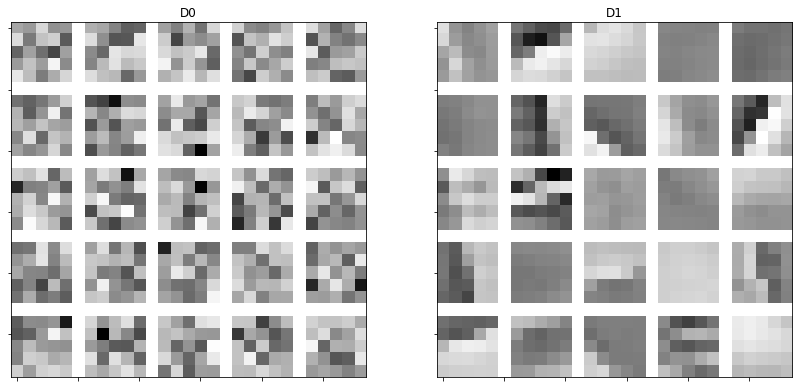

In [7]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14,7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[...,2,:]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[...,2,:]), fig=fig, title='D1')
fig.show()

Display initial and final dictionaries: central spatial vertical slice

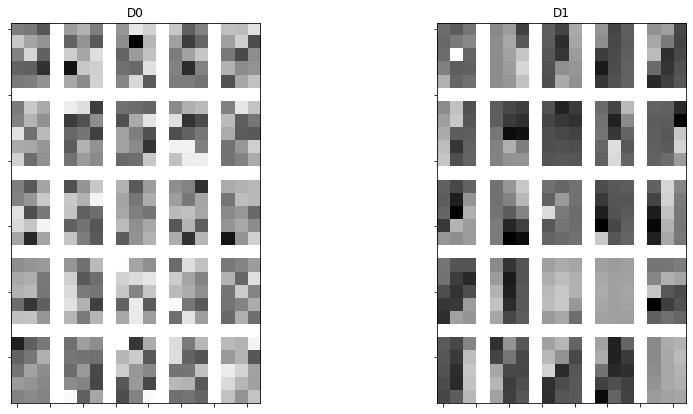

In [8]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[2]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[2]), fig=fig, title='D1')
fig.show()

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

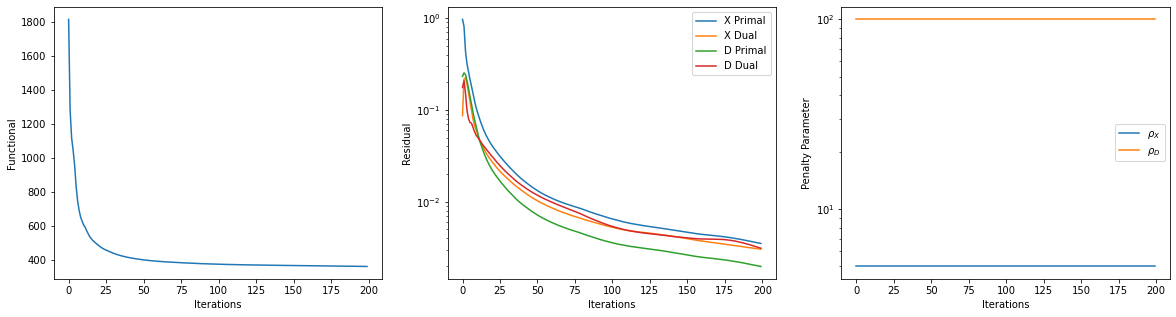

In [9]:
its = d.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.XPrRsdl, its.XDlRsdl, its.DPrRsdl, its.DDlRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['X Primal', 'X Dual', 'D Primal', 'D Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(np.vstack((its.XRho, its.DRho)).T, xlbl='Iterations',
          ylbl='Penalty Parameter', ptyp='semilogy',
          lgnd=['$\\rho_X$', '$\\rho_D$'], fig=fig)
fig.show()